In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob


def get_groundtruth(path: Path) -> pd.DataFrame:
    output_df = pd.DataFrame()
    
    for path in glob(str(path / 'train/*/*/ground_truth.csv')):
        _df = pd.read_csv(path)
        output_df = pd.concat([output_df, _df])
    output_df = output_df.reset_index(drop=True)
    
    _columns = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']
    output_df[['t_'+col for col in _columns]] = output_df[_columns]
    output_df = output_df.drop(columns=_columns, axis=1)
    return output_df


def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(a**0.5)
    dist = 6_367_000 * c
    return dist

def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df

In [3]:
# read data
BASE_DIR = Path('../input/google-smartphone-decimeter-challenge')
train_base = pd.read_csv(BASE_DIR / 'baseline_locations_train.csv')
test_base = pd.read_csv(BASE_DIR / 'baseline_locations_test.csv')

# merge graoundtruth
train_base = train_base.merge(
    get_groundtruth(BASE_DIR),
    on=['collectionName', 'phoneName', 'millisSinceGpsEpoch']
)

In [4]:
# check score
train_base = check_score(train_base)

error meter: 3.8468483749952074
score: 5.287970649047861


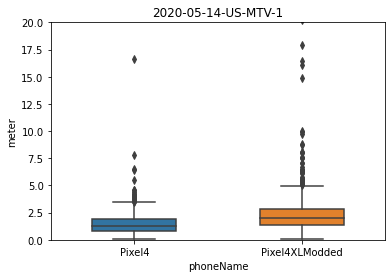

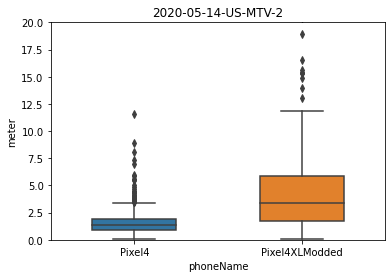

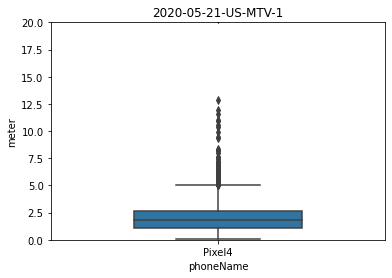

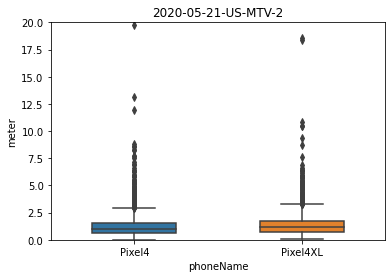

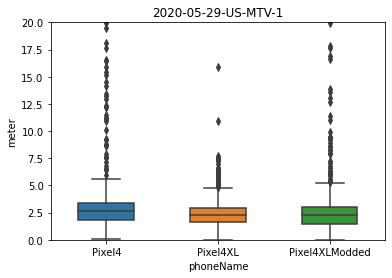

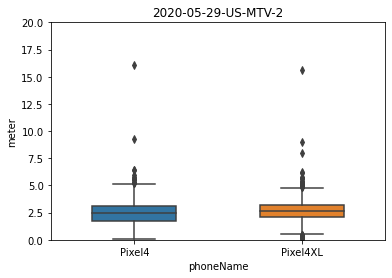

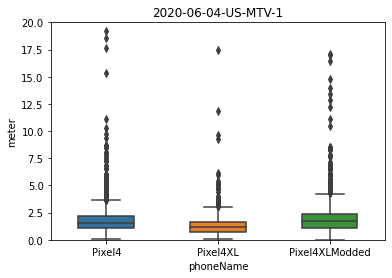

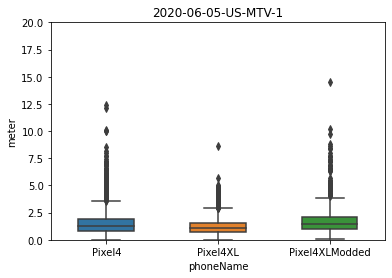

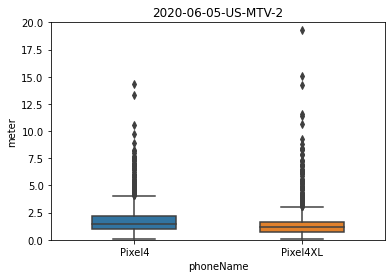

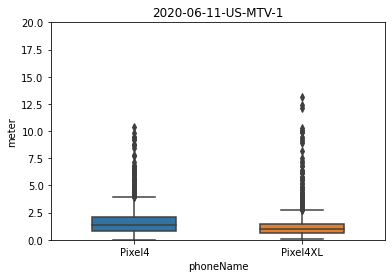

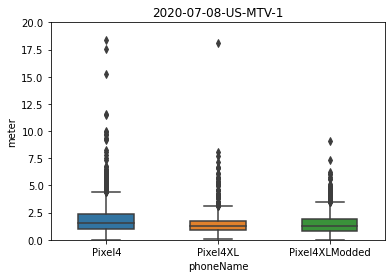

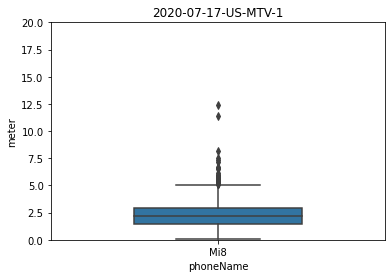

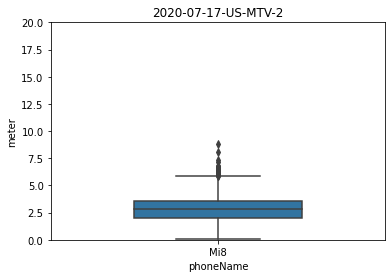

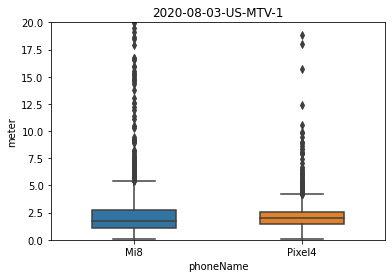

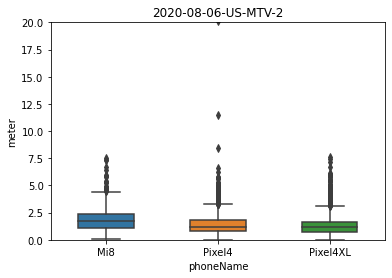

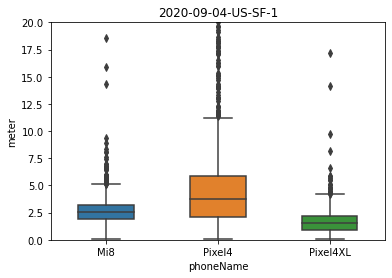

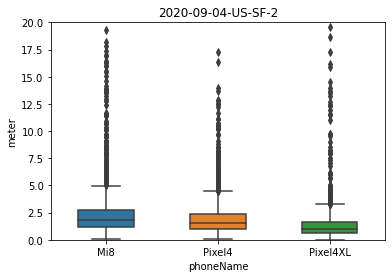

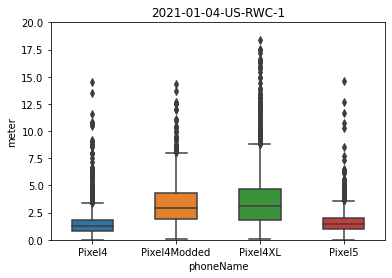

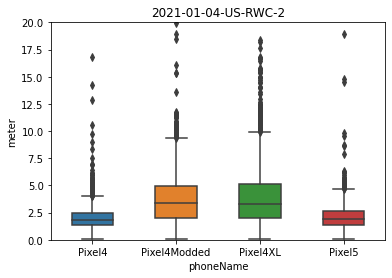

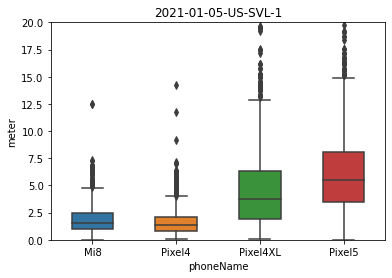

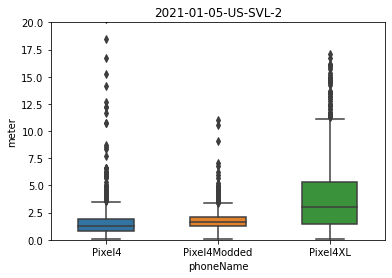

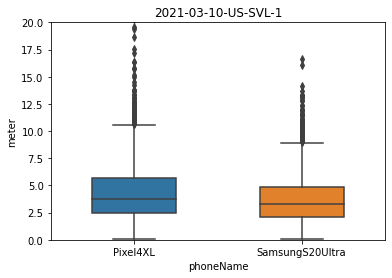

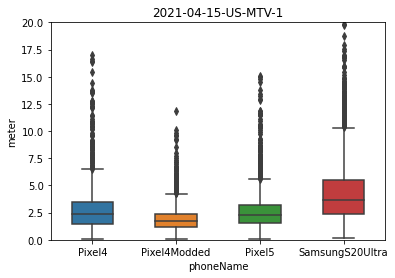

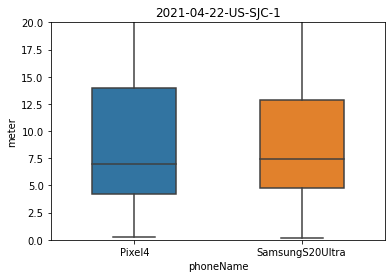

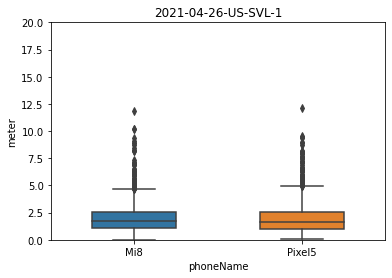

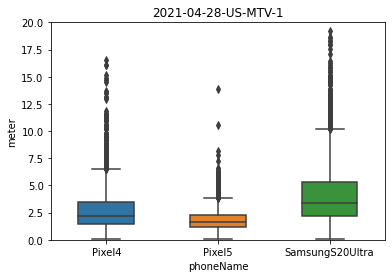

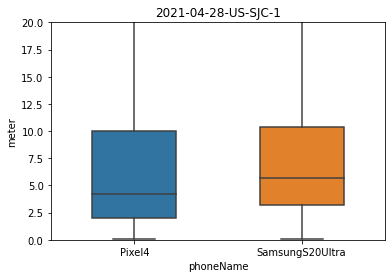

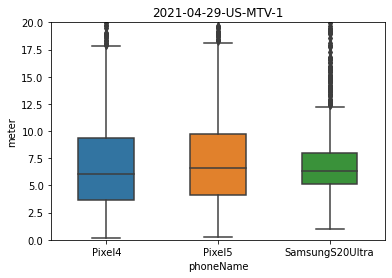

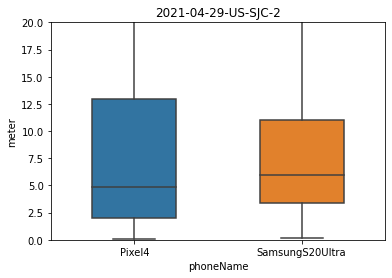

In [5]:
# show boxplot
for name, df in train_base.groupby('collectionName'):    
    sns.boxplot(data=df, x='phoneName', y='meter', width=0.5)
    plt.title(name)
    plt.ylim(0, 20)
    plt.show()

In [7]:
# show describe
train_base.groupby('phoneName')['meter'].describe().T

phoneName,Mi8,Pixel4,Pixel4Modded,Pixel4XL,Pixel4XLModded,Pixel5,SamsungS20Ultra
count,14169.000000,48153.000000,6927.000000,27710.000000,8388.000000,11791.000000,14204.000000
mean,3.781629,3.929690,2.801634,2.821935,2.253373,3.363772,7.482276
std,87.754586,14.556373,1.969832,10.116970,2.976209,6.970385,8.560503
min,0.001338,0.011203,0.054868,0.010101,0.021444,0.011386,0.039660
25%,1.296996,1.121951,1.463542,0.956195,1.137832,1.357711,3.047664
50%,2.044470,1.885689,2.234017,1.666033,1.819377,2.137115,5.149511
75%,2.929565,3.221244,3.689756,2.884074,2.667066,3.832652,8.464962
max,8340.257976,1599.570433,23.651914,238.779207,103.583319,653.703379,200.232033


- 同じcollectionnameでもdeviceによって誤差が異なる
- SamsungS20Ultraは誤差を多く含む
- 他のdeviceの位置情報から補間

In [8]:
def get_removedevice(input_df: pd.DataFrame, divece: str) -> pd.DataFrame:
    input_df['index'] = input_df.index
    input_df = input_df.sort_values('millisSinceGpsEpoch')
    input_df.index = input_df['millisSinceGpsEpoch'].values

    output_df = pd.DataFrame() 
    for _, subdf in input_df.groupby('collectionName'):

        phones = subdf['phoneName'].unique()

        if (len(phones) == 1) or (not divece in phones):
            output_df = pd.concat([output_df, subdf])
            continue

        origin_df = subdf.copy()
        
        _index = subdf['phoneName']==divece
        subdf.loc[_index, 'latDeg'] = np.nan
        subdf.loc[_index, 'lngDeg'] = np.nan
        subdf = subdf.interpolate(method='index', limit_area='inside')

        _index = subdf['latDeg'].isnull()
        subdf.loc[_index, 'latDeg'] = origin_df.loc[_index, 'latDeg'].values
        subdf.loc[_index, 'lngDeg'] = origin_df.loc[_index, 'lngDeg'].values

        output_df = pd.concat([output_df, subdf])

    output_df.index = output_df['index'].values
    output_df = output_df.sort_index()

    del output_df['index']
    
    return output_df

In [9]:
train_remove = get_removedevice(train_base, 'SamsungS20Ultra')

In [10]:
train_remove = check_score(train_remove)

error meter: 3.815171200513143
score: 5.172139630834808
